<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Fused_Representation_Hateful_Meme_ResNet_101_Balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fused Hateful Memes

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Extract Images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !gdown https://drive.google.com/uc?id=1wk0MzM3S6UKGxzEfGcmvDzHTefuUAJ_K

In [4]:
# import zipfile

# zip_path = '/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/fused_multimodel_hatefull.zip'
# extract_path = '/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/'

In [5]:
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
# path = "/content/multi_model-images-val.rar"

In [ ]:
# patoolib.extract_archive(path, outdir="/content/Data/" )

# Loading Training Dataset and Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    # def __getitem__(self, index):
    #     while True:
    #         try:
    #             image, label = self.dataset[index]
    #             return image, label
    #         except (UnidentifiedImageError, FileNotFoundError) as e:
    #             print(f"Error loading image at index {index}: {e}")
    #             index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [8]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/fused_multimodel_hatefull/fused_mulitmodal/train"
dataset = TrainingDataset(data_dir)

In [9]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 20050
Number of classes: 2


In [10]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [11]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 2
Total sum: 20050
dict_values([10900, 9150])


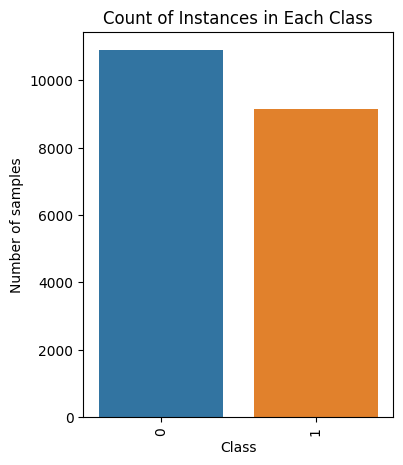

In [12]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(4, 5))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

# Loading ResNet-101

In [13]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 2


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 32

In [16]:
training_loss = []
resnet.train()

for epoch in range(num_epochs):
    # Set the model to training mode
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/32 Loss: 0.5637
Epoch 2/32 Loss: 0.4010
Epoch 3/32 Loss: 0.2276
Epoch 4/32 Loss: 0.1618
Epoch 5/32 Loss: 0.1187
Epoch 6/32 Loss: 0.0895
Epoch 7/32 Loss: 0.0718
Epoch 8/32 Loss: 0.0728
Epoch 9/32 Loss: 0.0518
Epoch 10/32 Loss: 0.0516
Epoch 11/32 Loss: 0.0485
Epoch 12/32 Loss: 0.0316
Epoch 13/32 Loss: 0.0283
Epoch 14/32 Loss: 0.0356
Epoch 15/32 Loss: 0.0276
Epoch 16/32 Loss: 0.0270
Epoch 17/32 Loss: 0.0171
Epoch 18/32 Loss: 0.0185
Epoch 19/32 Loss: 0.0233
Epoch 20/32 Loss: 0.0171
Epoch 21/32 Loss: 0.0147
Epoch 22/32 Loss: 0.0137
Epoch 23/32 Loss: 0.0110
Epoch 24/32 Loss: 0.0110
Epoch 25/32 Loss: 0.0124
Epoch 26/32 Loss: 0.0137
Epoch 27/32 Loss: 0.0092
Epoch 28/32 Loss: 0.0108
Epoch 29/32 Loss: 0.0167
Epoch 30/32 Loss: 0.0179
Epoch 31/32 Loss: 0.0167
Epoch 32/32 Loss: 0.0113


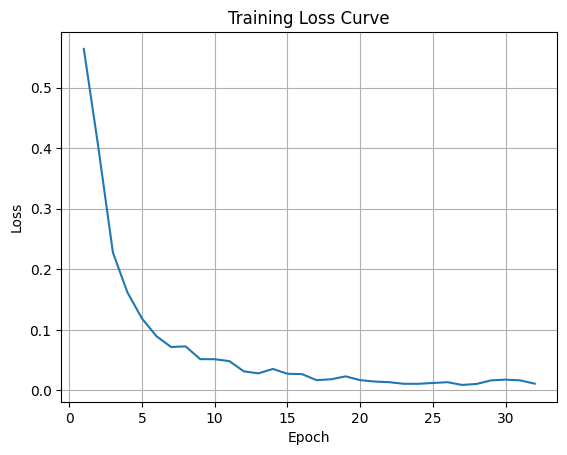

In [17]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Model

In [18]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/Hateful-Memes/Fused_ResNetmodel_Hatefull_Balanced"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
torch.save(resnet.state_dict(), save_path)